### AI generated example


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x)) ## 하나의 activation
        mu = self.fc_mu(h)      ## 평균을 모델링
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)   ## DNN은 음수도 반환하기 때문에 로그 스케일로 생성 후 exp를 씌워 양수로 변환
        eps = torch.randn_like(std) # Sample from a standard normal distribution
        return mu + eps * std       ## z를 생성.

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h)) # Sigmoid for pixel values between 0 and 1

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)            ## log p(x|z)
        return recon_x, mu, logvar

In [2]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (e.g., Binary Cross-Entropy for MNIST)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum') ## recon_x, x in (0, 1)이라면, Regression에서 BCE loss를 써도 잘 작동함.

    # KL Divergence between learned latent distribution and a standard normal prior
    # KL = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [3]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Hyperparameters
INPUT_DIM = 28 * 28
HIDDEN_DIM = 400
LATENT_DIM = 20
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10

# Data loading
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model, Optimizer
model = VAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, INPUT_DIM) # Flatten MNIST images
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)   ## 평균과 분산을 추가적으로 가져와야 함
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}')

100%|██████████| 9.91M/9.91M [00:03<00:00, 3.29MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 155kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.38MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 16.3MB/s]


Epoch 1, Loss: 164.0652
Epoch 2, Loss: 121.2239
Epoch 3, Loss: 114.2668
Epoch 4, Loss: 111.3249
Epoch 5, Loss: 109.6027
Epoch 6, Loss: 108.5222
Epoch 7, Loss: 107.6696
Epoch 8, Loss: 107.0225
Epoch 9, Loss: 106.4823
Epoch 10, Loss: 106.1292


> input $x$와 output $x'$간의 차이를 교정

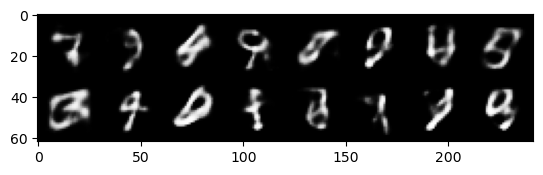

In [7]:
# Example of generating new images from the latent space
model.eval()
with torch.no_grad():
    z = torch.randn(16, LATENT_DIM) # Sample 16 random latent vectors
    generated_images = model.decode(z).view(-1, 1, 28, 28)

    # Visualize generated images (using matplotlib or torchvision.utils.make_grid)
    plt.imshow(torchvision.utils.make_grid(generated_images).permute(1, 2, 0))
    plt.show()

> 새로운 것을 생성할 때, 아예 임의의 값을 $z$로 넣어버리면 다른 것을 생성할 수 있음
>
> Latent vector의 각 값을 변화시켜가면서 어디에 영향을 미치는지 파악할 수 있음